In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr
import cartopy.crs as ccrs
from pyresample.geometry import AreaDefinition
from pyresample import image, geometry, load_area, save_quicklook, SwathDefinition, area_def2basemap
from pyresample.kd_tree import resample_nearest
from scipy import spatial
sys.path.append('./subroutines/')
from read_routines import read_usv, get_filelist_l2p,get_orbital_data_l2p
import warnings
warnings.simplefilter('ignore') # filter some warning messages
from glob import glob


In [2]:
dir_data = 'f:/data/cruise_data/saildrone/saildrone_data/'
dir_data_pattern = 'f:/data/cruise_data/saildrone/saildrone_data/*.nc'

list_var = ['time','lat','lon','SOG_MEAN','COG_MEAN','HDB_MEAN','ROLL_FILTERED_MEAN','PITCH_FILTERED_MEAN',
            'UWND_MEAN','VWND_MEAN','WWND_MEAN','GUST_WND_MEAN','TEMP_AIR_MEAN','RH_MEAN','BARO_PRES_MEAN',
            'PAR_AIR_MEAN','TEMP_CTD_MEAN','SAL_CTD_MEAN','TEMP_RBR_MEAN','SAL_RBR_MEAN',
            'TEMP_O2_RBR_MEAN']

swapvar = {'TEMP_SBE37_MEAN':'TEMP_CTD_MEAN','SAL_SBE37_MEAN':'SAL_CTD_MEAN','SAL_MEAN':'SAL_CTD_MEAN',
           'TEMP_O2_RBR_MEAN':'TEMP_O2_MEAN','TEMP_CTD_RBR_MEAN':'TEMP_RBR_MEAN'}


# read in list of saildrone files

In [3]:
files = [x for x in glob(dir_data_pattern)]

# Read in All Saildrone cruises downloaded from https://data.saildrone.com/data/sets
- 2017 onwards, note that earlier data is going to lack insruments and be poorer data quality in general
- For this code I want to develop a routine that reads in all the different datasets and creates a standardized set
- It may work best to first read each of the files individually into a dictionary 
- then go through each dataset finding all variable names
- I decided to put all SST into TEMP_CTD_MEAN and same for Salinity so there is a single variable name
- this still preserves all the dataset information

In [4]:
for ifile,file in enumerate(files):
    ds = xr.open_dataset(file).rename({'latitude':'lat','longitude':'lon'})
    if any(v=='trajectory' for v in ds.dims.keys()):
        ds = ds.isel(trajectory=0)
    ds.close()
    for v in ds.dims.keys():
        ds = ds.swap_dims({v:'time'})
    if ds.trajectory.size==1:
        iusv = float(ds.trajectory.data)
    else:
        iusv = float(ds.trajectory[0].data)

    #remove any duplicates in time, keep only first value
    _, index = np.unique(ds['time'], return_index=True)
    ds=ds.isel(time=index)
    #renames some common variables to uniform name, drop variables not on list above
    dssv = ds
    for var in ds:
        var2 = var
        if swapvar.get(var): 
            ds = ds.rename({var:swapvar.get(var)})
            var2 = swapvar.get(var)
        if any(vv==var2 for vv in list_var):
            ds #just a place holder does nothing
        else:
            ds = ds.drop(var2)
    #check that there is a TEMP_CTD_MEAN, if not & temp_rbr_mean there, change it to temp_ctd_mean
    if any(var=='TEMP_CTD_MEAN' for var in ds):
        ds #just a place holder does nothing
    else:
        if any(var=='TEMP_RBR_MEAN' for var in ds):
            ds = ds.rename({'TEMP_RBR_MEAN':'TEMP_CTD_MEAN'})
    if any(var=='SAL_CTD_MEAN' for var in ds):
        ds #just a place holder does nothing
    else:
        if any(var=='SAL_RBR_MEAN' for var in ds):
            ds = ds.rename({'SAL_RBR_MEAN':'SAL_CTD_MEAN'})
    if ds.attrs.get('project'):
        pname = ds.attrs['project']
    else:
        pname = ds.attrs['id']
    name = str(ds.time[0].dt.year.data)+'_'+str(int(iusv))+pname
    name = name.replace(" ", "_")
    name = name.replace("/", "_")
    print(name)
    if ifile==0:
        data_dict = {name:ds}
    else:
        data_dict[name]=ds
   


2018_1002baja_2018
2018_1001shark-2018
2018_1004shark-2018
2019_10211021_atlantic
2019_1020antarctica_circumnavigation_2019
2020_1026atomic_eurec4a_2020
2020_1060atomic_eurec4a_2020
2020_1061atomic_eurec4a_2020
2017_1001saildrone_arctic_data_2fb5_c534_0538
2017_1002saildrone_arctic_data_7586_9208_d693
2017_1003saildrone_arctic_data_ef8e_58e4_bb43
2019_1033NOAA_PMEL_2019_Arctic_Saildrone_Mission
2019_1034NOAA_PMEL_2019_Arctic_Saildrone_Mission
2019_1035NOAA_PMEL_2019_Arctic_Saildrone_Mission
2019_1036NOAA_PMEL_2019_Arctic_Saildrone_Mission
2019_1037NOAA_PMEL_2019_Arctic_Saildrone_Mission
2019_1041NOAA_PMEL_2019_Arctic_Saildrone_Mission
2017_1005TPOS-2020_Saildrone_Pilot_Study
2018_1005TPOS-2020_Saildrone_Pilot_Study
2017_1006TPOS-2020_Saildrone_Pilot_Study
2018_1006TPOS-2020_Saildrone_Pilot_Study
2018_1029TPOS-2020_Saildrone_Pilot_Study
2018_1030TPOS-2020_Saildrone_Pilot_Study
2019_1066TPOS-2020_Saildrone_Pilot_Study
2019_1067TPOS-2020_Saildrone_Pilot_Study
2019_1068TPOS-2020_Saildrone_

## An example showing how the using matplotlib maps orbital data quickly and easily


(25.0, 40.0)

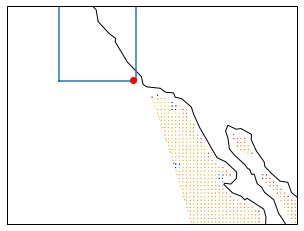

In [5]:
adir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/'
ds_usv = data_dict['2019_1039west_coast_survey_2019']
file = 'F:/data/sat_data/smap/SSS/L2/RSS/V3/40km/2018/115/RSS_SMAP_SSS_L2C_40km_r17250_20180425T004136_2018115_FNL_V03.0.nc'
ds = xr.open_dataset(file)
ds.close()
x = ds.cellon.data
y = ds.cellat.data
z = ds.sss_smap.data
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(x, y, s=1.0, c=z, edgecolor='none', cmap='jet')
minlon,maxlon,minlat,maxlat = ds_usv.lon.min().data,ds_usv.lon.max().data,ds_usv.lat.min().data,ds_usv.lat.max().data
ax.plot([minlon,maxlon,maxlon,minlon,minlon],[minlat,minlat,maxlat,maxlat,minlat])
#ax.plot(ds.cellon[jj,ii],ds.cellat[jj,ii,0],'b*')
ax.plot(ds_usv.lon[1000],ds_usv.lat[1000],'ro')
ax.coastlines()
ax.set_xlim(-130,-110)
ax.set_ylim(25,40)

# What lon range for satellite & insitu? are we going 0-360 or -180 to 180?

In [6]:
print(ds.cellon.min().data,ds.cellon.max().data)
print(ds_usv.lon.min().data,ds_usv.lon.max().data)

0.0034816479310393333 359.98931884765625
-126.4186624 -121.1346432


# okay, change all datasets in data_dict to 0 to 360 to match satellite

In [ ]:
data_dict_360 = data_dict.copy()
for name in data_dict:
    ds = data_dict[name]
    ds.coords['lon'] = np.mod(ds['lon'], 360)
    ds = ds.sortby(ds.lon)
    data_dict_360[name]=ds

In [ ]:
ds_usv = data_dict_360['2017_1001saildrone_arctic_data_2fb5_c534_0538']
print(ds_usv.lon.min().data,ds_usv.lon.max().data)

## First let's figure out what orbital files actually have data in our area of interest.  To do this, use the pyresample software

- read in the in situ data
- calculate the in situ min/max dates to know what files to check

Now we have our time of interest

- loop through the satellite data
- calculate the in situ min/max lat/lon on the same day to define a small box of interest
- use pyresample to map the data onto a predefined 0.1 deg resolution spatial grid
- subset the gridded map to the area of interest
- see if there is any valid data in that area
- if there is any valid data, go to next step

## Use the fast search kdtree which is part of pyresample software, but I think maybe comes originally from sci-kit-learn.

- read in the in situ data
- read in a single orbit of satellite data
- kdtree can't handle it when lat/lon are set to nan.  I frankly have no idea why there is orbital data for both the JPL and RSS products that have nan for the geolocation.  That isn't normal.  But, okay, let's deal with it.  
- stack the dataset scanline and cell positions into a new variable 'z'
- drop all variables from the dataset when the longitude is nan
- set up the tree
- loop through the orbital data
- only save a match if it is less than 0.25 deg distance AND time is less than any previous match
- save the satellite indices & some basic data onto the USV grid




In [ ]:
#effort to combine the finding & collocating code
#intialize grid
adir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/'
#for name in data_dict:
for iname,name in enumerate(data_dict):
    area_def = load_area('areas.cfg', 'pc_world')
    rlon=np.arange(-180,180,.1)
    rlat=np.arange(90,-90,-.1)

    for isat in range(0,1):

        ds_usv,name_usv=data_dict[name],name

        if isat==0:
            fileout = 'F:/data/cruise_data/saildrone/sss_collocations/'+name_usv+'rssv4_filesave3.nc'
        if isat==1:
            fileout = 'F:/data/cruise_data/saildrone/sss_collocations/'+name_usv+'jplv4.2_filesave3.nc'   

#        if path.exists(fileout):
#            continue

        #search usv data
        minday,maxday = ds_usv.time[0],ds_usv.time[-1]
        usv_day = minday
        print(iname,name)
        print(minday.data,maxday.data)
        while usv_day<=maxday:
            ds_day = ds_usv.sel(time=slice(usv_day-np.timedelta64(1,'D'),usv_day+np.timedelta64(1,'D')))
            ilen = ds_day.time.size
            if ilen<1:   #don't run on days without any data
                continue
            minlon,maxlon,minlat,maxlat = ds_day.lon.min().data,ds_day.lon.max().data,ds_day.lat.min().data,ds_day.lat.max().data
            filelist = get_filelist_l2p(isat, usv_day)
            x,y,z = [],[],[]
            for file in filelist:
                ds = xr.open_dataset(file)
                ds.close()  
                if isat==0:  #change RSS data to conform with JPL definitions
                    ds = ds.isel(look=0)
                    ds = ds.rename({'iqc_flag':'quality_flag','cellon':'lon','cellat':'lat','sss_smap':'smap_sss','ydim_grid':'phony_dim_0','xdim_grid':'phony_dim_1'})
                    ds['lon']=np.mod(ds.lon+180,360)-180  
                if isat==1:  #change RSS data to conform with JPL definitions
                    ds = ds.rename({'row_time':'time'})

#first do a quick check using resample to project the orbit onto a grid 
#and quickly see if there is any data in the cruise area on that day
#if there is, then continue to collocation

                x = ds['lon'].fillna(-89).data 
                y = ds['lat'].fillna(-89).data 
                z = ds['smap_sss'].data 
                lons,lats,data = x,y,z 
                swath_def = SwathDefinition(lons, lats)
                result1 = resample_nearest(swath_def, data, area_def, radius_of_influence=20000, fill_value=None)
                da = xr.DataArray(result1,name='sss',coords={'lat':rlat,'lon':rlon},dims=('lat','lon'))
                subset = da.sel(lat = slice(maxlat,minlat),lon=slice(minlon,maxlon))
                num_obs = np.isfinite(subset).sum()
                if num_obs<1:  #no collocations so go to next orbit
                    continue

                #stack xarray dataset then drop lon == nan
                ds2 = ds.stack(z=('phony_dim_0', 'phony_dim_1')).reset_index('z')
                #drop nan
                ds_drop = ds2.where(np.isfinite(ds2.lon),drop=True)
                lats = ds_drop.lat.data
                lons = ds_drop.lon.data
                inputdata = list(zip(lons.ravel(), lats.ravel()))
                tree = spatial.KDTree(inputdata)
                orbit_time = ds.time.max().data-np.timedelta64(1,'D')
                orbit_time2 = ds.time.max().data+np.timedelta64(1,'D')    
                ilen = ds_usv.time.size
                for iusv_index in range(200): #range(ilen):
                    if (ds_usv.time[iusv_index]<orbit_time) or (ds_usv.time[iusv_index]>orbit_time2):
                        continue
                    pts = np.array([ds_usv.lon[iusv_index], ds_usv.lat[iusv_index]])
            #        pts = np.array([ds_usv.lon[iusv]+360, ds_usv.lat[iusv]])
                    tree.query(pts,k=1)
                    i = tree.query(pts)[1]
                    rdist = tree.query(pts)[0]
                    #don't use matchups more than 25 km away
                    if rdist>.25:
                        continue
                    #use .where to find the original indices of the matched data point
                    #find by matching sss and lat, just randomly chosen variables, you could use any
                    result = np.where((ds.smap_sss == ds_drop.smap_sss[i].data) & (ds.lat == ds_drop.lat[i].data))
                    listOfCoordinates = list(zip(result[0], result[1]))
                    if len(listOfCoordinates)==0:
                        continue
                    ii, jj = listOfCoordinates[0][0],listOfCoordinates[0][1]
                    if isat==0:
                        deltaTa = ((ds_usv.time[iusv_index]-ds.time[ii,jj]).data)/ np.timedelta64(1,'m')
                    if isat==1:
                        deltaTa = ((ds_usv.time[iusv_index]-ds.time[ii]).data)/ np.timedelta64(1,'m')
                    if np.abs(deltaTa)<np.abs(ds_usv.deltaT[iusv_index].data):
                        ds_usv.deltaT[iusv_index]=deltaTa
                        ds_usv.smap_SSS[iusv_index]=ds.smap_sss[ii,jj]
                        ds_usv.smap_iqc_flag[iusv_index]=ds.quality_flag[ii,jj]
                        ds_usv.smap_name[iusv_index]=file
                        ds_usv.smap_dist[iusv_index]=rdist
                        ds_usv.smap_ydim[iusv_index]=ii
                        ds_usv.smap_xdim[iusv_index]=jj
            usv_day += np.timedelta64(1,'D')
        ds_usv.to_netcdf(fileout)

